In [1]:
#Modules
import pickle
import numpy as np
import networkx as nx
import pathway_analysis as pa

# Submodules
from cdlib import algorithms
from matplotlib import pyplot as plt


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [2]:
G = nx.read_gpickle('data/protein_graph')

In [3]:
pa.print_graph_properties(G)

Number of nodes: 6144
Number of edges: 338449
Density: 0.018
Is connected: True
Number of connected components: 1
Largest connected component: 6144 (1.00%)
Number of isolated nodes: 0 (0.00%)
Number of self loops: 8


### Community detection

In [4]:
cs = algorithms.coach(G, density_threshold=0.85, affinity_threshold=0.2, closeness_threshold=0.85)
print('Number of communities detected: ', len(cs.communities))

Number of communities detected:  2954


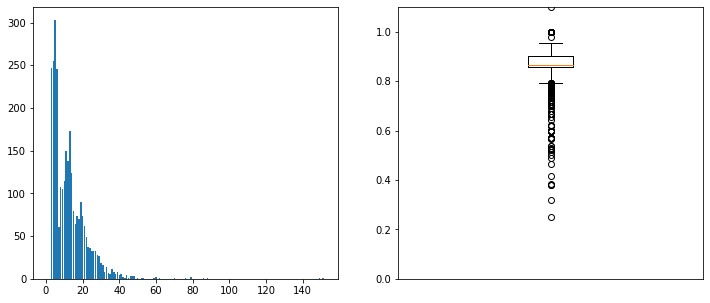

In [5]:
communities_size = np.array([len(c) for c in cs.communities])
communities_size.sort()
positions = np.arange(1, communities_size[-1]+1)
count = np.zeros(communities_size[-1])
for i in range(1, communities_size[-1]+1):
    x = len(communities_size[communities_size == i])
    if x != 0:
        count[i-1] = x

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs.flatten()
axs[0].bar(positions, count)
densities = [nx.density(G.subgraph(c)) for c in cs.communities]
axs[1].boxplot(densities)
axs[1].set_ylim(0, 1.1)
axs[1].set_xticks([])
fig.savefig('../../communities.jpg', bbox_inches='tight')
plt.show()

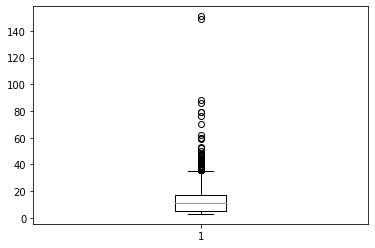

In [6]:
plt.boxplot(communities_size)
plt.show()

In [7]:
covered_nodes = len(set.union(*[set(c) for c in cs.communities]))
print(covered_nodes)
print(covered_nodes/G.number_of_nodes())

4876
0.7936197916666666


844


[]

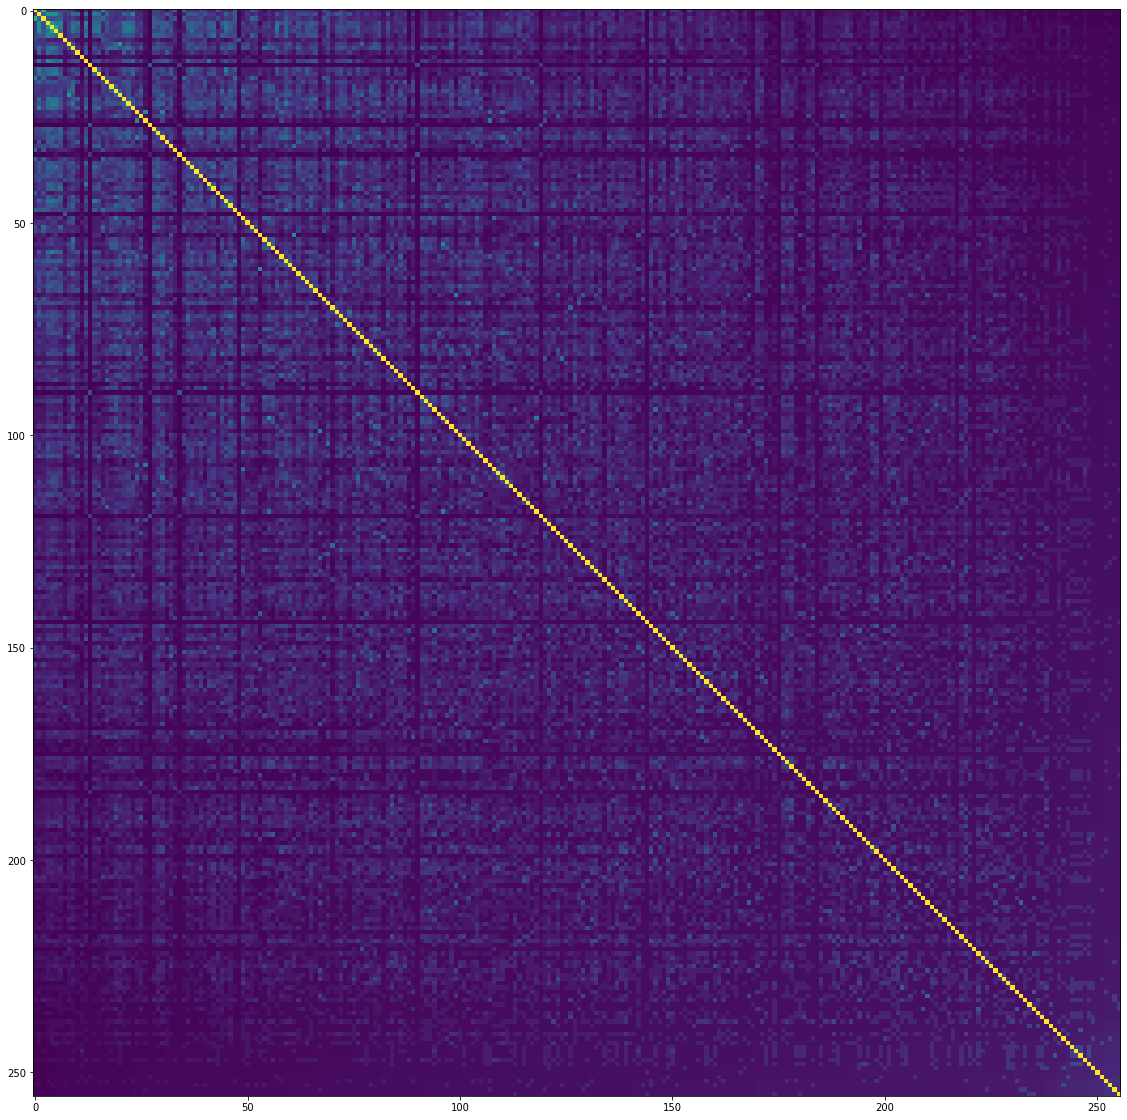

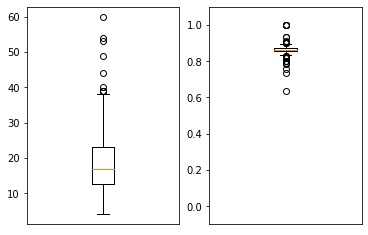

In [44]:
def jacc(S: set, T: set):
    inters = S.intersection(T)
    union = S.union(T)
    return len(inters)/len(union)


def jaccard_matrix(gene: str):
    modules = [set(cs.communities[index]) for index in cs.to_node_community_map()[gene]]
    jaccard_matrix = np.zeros((len(modules), len(modules)))
    for i in range(len(modules)):
        for j in range(i+1):
            jaccard_score = jacc(modules[i], modules[j])
            jaccard_matrix[i, j] = jaccard_score
            jaccard_matrix[j, i] = jaccard_score
    return jaccard_matrix

gene = 'MEC1'
jm = jaccard_matrix(gene)
communities = [set(cs.communities[c]) for c in cs.to_node_community_map()[gene]]
all_nodes = set.union(*communities)
print(len(all_nodes))

fig, ax = plt.subplots(1)
fig.set_size_inches(20, 20)
ax.imshow(jm)

fig, axs = plt.subplots(1, 2)
axs.flatten()

sizes = [len(c) for c in communities]
axs[0].boxplot(sizes)
#axs[0].set_ylim(-0.1, 1.1)
axs[0].set_xticks([])


densities = [nx.density(G.subgraph(c)) for c in communities]
axs[1].boxplot(densities)
axs[1].set_ylim(-0.1, 1.1)
axs[1].set_xticks([])


In [8]:
with open('data/communities.pickle', 'wb') as f:
    pickle.dump(cs ,f)
f.close()

### Find modules
* For each node (disease or target)
    * Get all the communities containing that node
    * Merge them


In [9]:
def get_modules(cs, node):
    coms = cs.to_node_community_map()
    indexes = coms[node]
    return [cs.communities[ind] for ind in indexes]

In [10]:
dis_genes_modules = {n: get_modules(cs, n) for n, dis in G.nodes(data='disease') if dis}
tar_genes_modules = {n: get_modules(cs, n) for n, tar in G.nodes(data='target') if tar}

In [11]:
lost_dis_genes = [x for x, item in dis_genes_modules.items() if len(item) == 0]
lost_tar_genes = [x for x, item in tar_genes_modules.items() if len(item) == 0]

In [12]:
for elem in lost_dis_genes:
    del dis_genes_modules[elem]
for elem in lost_tar_genes:
    del tar_genes_modules[elem]

### Save both the disease's and target's modules

In [13]:
with open('data/dis_genes_modules.pickle', 'wb') as f:
    pickle.dump(dis_genes_modules, f)
f.close()
with open('data/tar_genes_modules.pickle', 'wb') as f:
    pickle.dump(tar_genes_modules, f)
f.close()